<a href="https://colab.research.google.com/github/LauraPrieto0124/Colombia_EKC_estimation/blob/main/SO4SMASS_ESDA_in_phyton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analisys (ESDA) for SO4SMASS concentration in Colombia between 2016 - 2022

# Setup

In [ ]:
# Adding necessary libraries to Google Colab environment

# Installing the 'contextily' library for adding basemaps to plots
!pip install contextily -q

# Installing the 'splot' library for spatial data visualization
!pip install splot -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 18.6 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries for data analysis and visualization
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  # Importing matplotlib image for image plotting
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

# Importing libraries for spatial data and visualization
import geopandas as gpd
import folium
from folium import Figure

import contextily as cx

import libpysal
from libpysal  import weights
from libpysal.weights import Queen

# Exploratory Spatial Data Analysis (ESDA) tools
import mapclassify as mc
import esda
from esda.moran import Moran, Moran_Local

# Spatial plotting tools
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights
from splot.mapping import vba_choropleth

# Statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the URL where the GeoJSON data is located
gdf = gpd.read_file("/content/drive/MyDrive/Earthengine/BBDD/2016_2022_Zonal_several_pollutants.geojson")

In [ ]:
gdf.head(3)

id  ADM0_CODE ADM0_NAME  ADM1_CODE ADM1_NAME  \
0  0_00020000000000001bf9         57  Colombia        934  Amazonas   
1  0_00020000000000001bfa         57  Colombia        934  Amazonas   
2  0_00020000000000001bfb         57  Colombia        934  Amazonas   

   ADM2_CODE    ADM2_NAME  BCSMASS_mean DISP_AREA  DMSSMASS_mean  \
0      13333   El Encanto  1.733770e-10        NO   1.096390e-12   
1      13334  La Chorrera  1.691294e-10        NO   1.467137e-12   
2      13335   La Pedrera  1.776440e-10        NO   2.330614e-12   

   DUSMASS_mean  EXP2_YEAR  OCSMASS_mean  SO2SMASS_mean  SO4SMASS_mean  \
0  4.277700e-09       3000  3.806302e-09   5.878729e-11   3.091652e-10   
1  4.562164e-09       3000  3.879111e-09   4.728144e-11   3.019676e-10   
2  5.371289e-09       3000  4.178771e-09   6.928289e-11   2.842322e-10   

         STATUS  STR2_YEAR  Shape_Area  Shape_Leng  system:time_start  year  \
0  Member State       1000    0.880307    7.970986      1451606400000  2016   
1  Member State       1000    1.806759    7.253629      1451606400000  2016   
2  Member State       1000    1.961139    9.741906      1451606400000  2016   

                                            geometry  
0  POLYGON ((-74.39066 -0.59288, -74.38841 -0.601...  
1  POLYGON ((-72.62549 -2.42766, -72.62325 -2.423...  
2  MULTIPOLYGON (((-69.42529 -1.06898, -69.42305 ...

In [ ]:
LOG_OFFSET = 0.01
scaling_factor = 1000
gdf["SO4SMASS_mean"] = np.log(scaling_factor * (LOG_OFFSET + (1000000000 * gdf["SO4SMASS_mean"])))

In [ ]:
# Pivotear sin incluir la columna de geometría
gdf_pivoted = gdf.drop(columns="geometry").pivot(index=['ADM0_CODE', "ADM0_NAME", "ADM1_CODE", "ADM1_NAME",
                             "ADM2_CODE", "ADM2_NAME", "Shape_Area", "Shape_Leng"], columns='year', values='SO4SMASS_mean')

gdf_pivoted = gdf_pivoted.reset_index() # This line is added to reset the index

# Volver a unir la columna de geometría si necesitas mantenerla en el resultado
gdf_pivoted = gdf[['ADM2_CODE', 'geometry']].drop_duplicates().merge(gdf_pivoted, on='ADM2_CODE')

# Mostrar el resultado
gdf_pivoted.head()

ADM2_CODE                                           geometry  ADM0_CODE  \
0      13333  POLYGON ((-74.39066 -0.59288, -74.38841 -0.601...         57   
1      13334  POLYGON ((-72.62549 -2.42766, -72.62325 -2.423...         57   
2      13335  MULTIPOLYGON (((-69.42529 -1.06898, -69.42305 ...         57   
3      13336  POLYGON ((-70.31012 -3.60219, -70.30787 -3.622...         57   
4      13337  POLYGON ((-69.9508 -1.12962, -69.95305 -1.1318...         57   

  ADM0_NAME  ADM1_CODE ADM1_NAME      ADM2_NAME  Shape_Area  Shape_Leng  \
0  Colombia        934  Amazonas     El Encanto    0.880307    7.970986   
1  Colombia        934  Amazonas    La Chorrera    1.806759    7.253629   
2  Colombia        934  Amazonas     La Pedrera    1.961139    9.741906   
3  Colombia        934  Amazonas        Leticia    0.325636    2.557618   
4  Colombia        934  Amazonas  Miriti Parana    1.345336    7.145437   

       2016      2017      2018      2019      2020      2021  
0  5.765709  5.946404  5.827080  5.911010  5.949611  5.862091  
1  5.742899  5.922069  5.819240  5.894224  5.928532  5.868648  
2  5.684369  5.822073  5.687557  5.833006  5.835032  5.800589  
3  5.756871  5.783476  5.685247  5.825231  5.899195  5.825413  
4  5.667151  5.814179  5.667336  5.855059  5.819497  5.759472

In [ ]:
new_column_names = {
    2016: 'SO4SMASS_2016',
    2017: 'SO4SMASS_2017',
    2018: 'SO4SMASS_2018',
    2019: "SO4SMASS_2019",
    2020: "SO4SMASS_2020",
    2021: "SO4SMASS_2021"
}

gdf_pivoted = gdf_pivoted.rename(columns=new_column_names)

gdf_pivoted.head(3)

ADM2_CODE                                           geometry  ADM0_CODE  \
0      13333  POLYGON ((-74.39066 -0.59288, -74.38841 -0.601...         57   
1      13334  POLYGON ((-72.62549 -2.42766, -72.62325 -2.423...         57   
2      13335  MULTIPOLYGON (((-69.42529 -1.06898, -69.42305 ...         57   

  ADM0_NAME  ADM1_CODE ADM1_NAME    ADM2_NAME  Shape_Area  Shape_Leng  \
0  Colombia        934  Amazonas   El Encanto    0.880307    7.970986   
1  Colombia        934  Amazonas  La Chorrera    1.806759    7.253629   
2  Colombia        934  Amazonas   La Pedrera    1.961139    9.741906   

   SO4SMASS_2016  SO4SMASS_2017  SO4SMASS_2018  SO4SMASS_2019  SO4SMASS_2020  \
0       5.765709       5.946404       5.827080       5.911010       5.949611   
1       5.742899       5.922069       5.819240       5.894224       5.928532   
2       5.684369       5.822073       5.687557       5.833006       5.835032   

   SO4SMASS_2021  
0       5.862091  
1       5.868648  
2       5.800589

In [ ]:
for col in ['SO4SMASS_2016', "SO4SMASS_2017", "SO4SMASS_2018", "SO4SMASS_2019", "SO4SMASS_2020", "SO4SMASS_2021"]:
    gdf_pivoted[col] = pd.to_numeric(gdf_pivoted[col], errors='coerce')

In [ ]:
gdf_pivoted = gdf_pivoted.dropna(subset=['SO4SMASS_2016', "SO4SMASS_2017", "SO4SMASS_2018", "SO4SMASS_2019", "SO4SMASS_2020", "SO4SMASS_2021"])

In [ ]:
gdf_pivoted[["ADM2_CODE", "ADM0_CODE", "ADM1_CODE", "Shape_Area", "Shape_Leng"]] = gdf_pivoted[["ADM2_CODE", "ADM0_CODE", "ADM1_CODE", "Shape_Area", "Shape_Leng"]].astype(str)

In [ ]:
gdf_pivoted.describe()

SO4SMASS_2016  SO4SMASS_2017  SO4SMASS_2018  SO4SMASS_2019  \
count    1078.000000    1078.000000    1078.000000    1078.000000   
mean        6.782141       6.690491       6.639583       6.759083   
std         0.349302       0.315924       0.308095       0.301171   
min         5.603526       5.707253       5.524287       5.777818   
25%         6.580579       6.509906       6.446347       6.578891   
50%         6.873344       6.754462       6.673954       6.794964   
75%         7.053066       6.899266       6.864001       6.976134   
max         7.374788       7.279906       7.239465       7.500411   

       SO4SMASS_2020  SO4SMASS_2021  
count    1078.000000    1078.000000  
mean        6.790968       6.687285  
std         0.269301       0.356518  
min         5.673438       5.480115  
25%         6.642632       6.507662  
50%         6.819223       6.734983  
75%         6.981336       6.928375  
max         7.295872       7.357842

# Plot map

In [ ]:
island_names= ['Turbo (is.)', "Cartagena (dist. Esp.) (i", "Gorgona (is.)", "Monitos (is.)", "Santa Marta (dist. Esp.)(",
               "Tumaco (is.)", "San Andres Y Providencia", "San Onofre (is.)", "Name Unknown", "Santa Catalina", "Santa Catarina", "Guapi (is.)", "Timbiqui (is.)",
               "Bajo Baudo (is.)", "Jurado (is.)", "San Bernardo El Viento (i", "Mosquera (is.)", "Necocli (is.)", 	"	Buenaventura (is.)" ]

gdf_pivoted = gdf_pivoted[~gdf_pivoted['ADM2_NAME'].isin(island_names)]

In [ ]:
from shapely.geometry import MultiPolygon

def convert_to_multipolygon(geom):
    if geom.type == 'GeometryCollection':
        polygons = [g for g in geom.geoms if g.type in ['Polygon', 'MultiPolygon']]
        return MultiPolygon(polygons)
    return geom

# Aplicar a una GeoDataFrame
gdf_pivoted.geometry = gdf_pivoted.geometry.apply(convert_to_multipolygon)

In [ ]:
tipos_geometria = gdf_pivoted.geom_type.unique()
print(tipos_geometria)

['Polygon' 'MultiPolygon']


In [ ]:
# Visualize spatial data using the explore() method of a GeoDataFrame
gdf_pivoted.explore(
    # Specify the column to visualize on the map
    column= "SO4SMASS_2021",
    # Specify2a the attributes to display in the tooltip when hovering over map features
    tooltip=["ADM1_NAME", 'ADM2_NAME', 'SO4SMASS_2016'],
    # Choose the classification scheme for data visualization
    scheme='NaturalBreaks',
    # Specify the number of classes for classification
    k= 3,
    # Choose the colormap for data visualization
    cmap='coolwarm',
    # Specify whether to display a legend
    legend=True,
    # Choose the basemap tiles provider
    tiles='CartoDB positron',
    # Customize the style of the basemap tiles
    style_kwds=dict(color="gray", weight=0.5),
    # Customize the appearance of the legend
    legend_kwds=dict(colorbar=False)
)

# Spatial weights and lags

In [ ]:
# Create a spatial weight matrix using queen criteria
queen_weights = Queen.from_dataframe(gdf_pivoted)
# Verify the amount of neighbors
neighbors_count = [len(queen_weights.neighbors[i]) for i in range(queen_weights.n)]
print("Neighbors amount:")
print(f"Max neighbords: {max(neighbors_count)}")
print(f"Min neigbords: {min(neighbors_count)}")
print(f"Neighbors average: {sum(neighbors_count) / len(neighbors_count):.2f}")

Neighbors amount:
Max neighbords: 20
Min neigbords: 1
Neighbors average: 5.99


In [ ]:
# Reproject to use contextily
gdf_pivoted = gdf_pivoted.to_crs(epsg=3116)

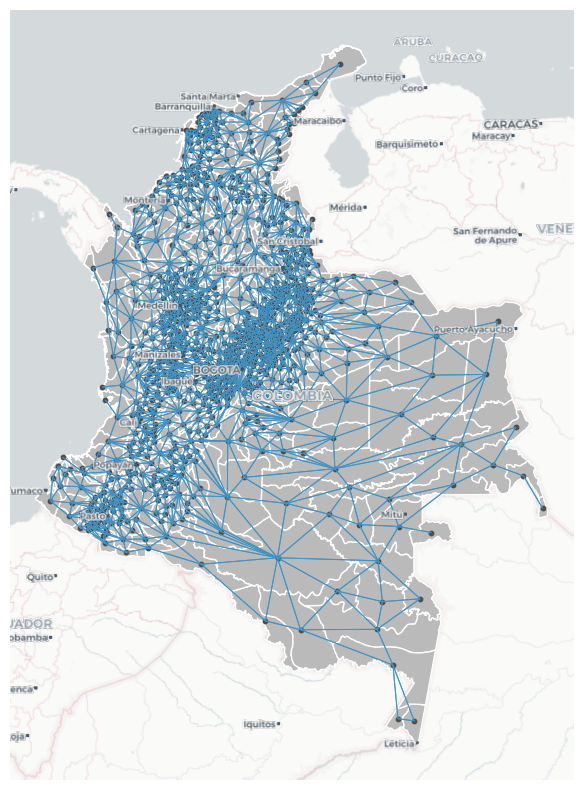

In [ ]:
# Plot the spatial weights using splot library and queen matrix
# This will visualize the spatial relationships between observations defined by the weights matrix W
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14,10))
plot_spatial_weights(queen_weights, gdf_pivoted, ax=ax)
cx.add_basemap(ax, crs=gdf_pivoted.crs.to_string(), source = cx.providers.CartoDB.Positron,           attribution=False)
cx.add_basemap(ax, crs=gdf_pivoted.crs.to_string(), source = cx.providers.CartoDB.PositronOnlyLabels, attribution=False)
plt.show()

In [ ]:
#@title Obtaining the k nearest weight matrix
gdf_pivoted['centroid'] = gdf_pivoted.geometry.centroid

gdf_pivoted['lon'] = gdf_pivoted['centroid'].x
gdf_pivoted['lat'] = gdf_pivoted['centroid'].y

coords = gdf_pivoted[['lon', 'lat']].value

k = 5
weights_KNN = libpysal.weights.KNN(coords, k=k)

In [ ]:
# Reproject to use contextily
gdf_pivoted = gdf_pivoted.to_crs(epsg=3116)

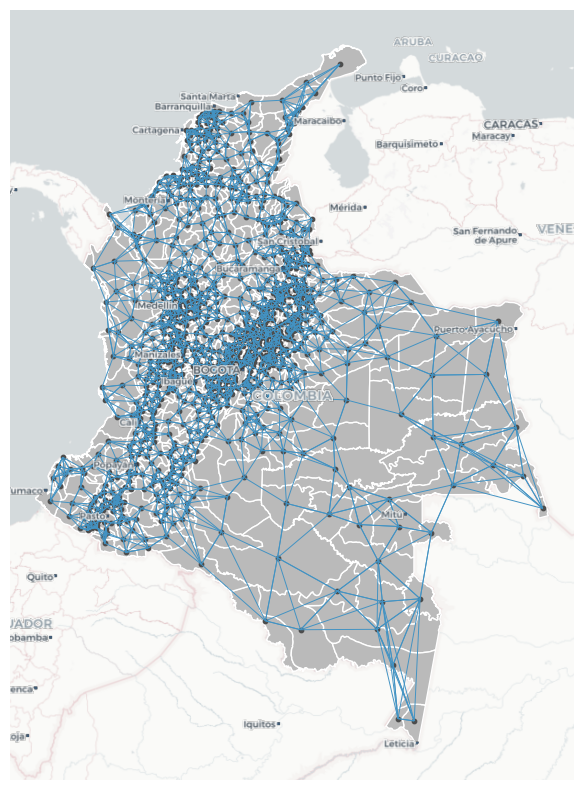

In [ ]:
# Plot the spatial weights using splot library and KNN matrix

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14,10))
plot_spatial_weights(weights_KNN, gdf_pivoted, ax=ax)
cx.add_basemap(ax, crs=gdf_pivoted.crs.to_string(), source = cx.providers.CartoDB.Positron,           attribution=False)
cx.add_basemap(ax, crs=gdf_pivoted.crs.to_string(), source = cx.providers.CartoDB.PositronOnlyLabels, attribution=False)
plt.show()

# Global spatial dependence

In [ ]:
# Compute Global Moran's I statistic for the 'PM2' variables using the spatial weights matrix W
globalMoran_2016 = Moran(gdf_pivoted['SO4SMASS_2016'], weights_KNN)
globalMoran_2017 = Moran(gdf_pivoted['SO4SMASS_2017'], weights_KNN)
globalMoran_2018 = Moran(gdf_pivoted['SO4SMASS_2018'], weights_KNN)
globalMoran_2019 = Moran(gdf_pivoted['SO4SMASS_2019'], weights_KNN)
globalMoran_2020 = Moran(gdf_pivoted['SO4SMASS_2020'], weights_KNN)
globalMoran_2021 = Moran(gdf_pivoted['SO4SMASS_2021'], weights_KNN)
# Format Moran's I statistic to two decimal places
moranI_2016 = "{:.2f}".format(globalMoran_2016.I)
moranI_2017 = "{:.2f}".format(globalMoran_2017.I)
moranI_2018 = "{:.2f}".format(globalMoran_2018.I)
moranI_2019 = "{:.2f}".format(globalMoran_2019.I)
moranI_2020 = "{:.2f}".format(globalMoran_2020.I)
moranI_2021 = "{:.2f}".format(globalMoran_2021.I)

# Print Moran's I statistic
print(moranI_2016, moranI_2017, moranI_2018, moranI_2019, moranI_2020, moranI_2021)

0.96 0.95 0.95 0.94 0.94 0.96


In [ ]:
print(globalMoran_2016.p_sim)
print(globalMoran_2017.p_sim)
print(globalMoran_2018.p_sim)
print(globalMoran_2019.p_sim)
print(globalMoran_2020.p_sim)
print(globalMoran_2021.p_sim)

0.001
0.001
0.001
0.001
0.001
0.001


In [ ]:
# Calculate spatial lag of SO4SMASS using the specified weights
gdf_pivoted['wimds_2016'] = weights.lag_spatial(weights_KNN, gdf_pivoted['SO4SMASS_2016'])
gdf_pivoted["wimds_2017"] = weights.lag_spatial(weights_KNN, gdf_pivoted['SO4SMASS_2017'])
gdf_pivoted["wimds_2018"] = weights.lag_spatial(weights_KNN, gdf_pivoted['SO4SMASS_2018'])
gdf_pivoted["wimds_2019"] = weights.lag_spatial(weights_KNN, gdf_pivoted['SO4SMASS_2019'])
gdf_pivoted["wimds_2020"] = weights.lag_spatial(weights_KNN, gdf_pivoted['SO4SMASS_2020'])
gdf_pivoted["wimds_2021"] = weights.lag_spatial(weights_KNN, gdf_pivoted['SO4SMASS_2021'])

# Local spatial dependence

In [ ]:
# Calculate Local Moran's I statistics
# gdf['PM2.5_2016'] is the variable for which local spatial autocorrelation is computed
# Queen_weights is the spatial weights matrix defining the spatial relationships between observations
# permutations specifies the number of random permutations for statistical inference
# seed sets the seed for reproducibility of random permutations
moranLocal_2016 = Moran_Local(gdf_pivoted['SO4SMASS_2016'], weights_KNN, permutations=999, seed=12345)
moranLocal_2017 = Moran_Local(gdf_pivoted['SO4SMASS_2017'], weights_KNN, permutations=999, seed=12345)
moranLocal_2018 = Moran_Local(gdf_pivoted['SO4SMASS_2018'], weights_KNN, permutations=999, seed=12345)
moranLocal_2019 = Moran_Local(gdf_pivoted['SO4SMASS_2019'], weights_KNN, permutations=999, seed=12345)
moranLocal_2020 = Moran_Local(gdf_pivoted['SO4SMASS_2020'], weights_KNN, permutations=999, seed=12345)
moranLocal_2021 = Moran_Local(gdf_pivoted['SO4SMASS_2021'], weights_KNN, permutations=999, seed=12345)

In [ ]:
gdf_pivoted['ADM2_NAME'] = gdf_pivoted['ADM2_NAME'].replace('Santafe De Bogota D.c.', 'Bogota')
gdf_pivoted['ADM2_NAME'] = gdf_pivoted['ADM2_NAME'].replace('Cartagena (dist. Esp.)', 'Cartagena')
gdf_pivoted['ADM2_NAME'] = gdf_pivoted['ADM2_NAME'].replace("Barranquilla  (dist.port.", 'Barranquilla')

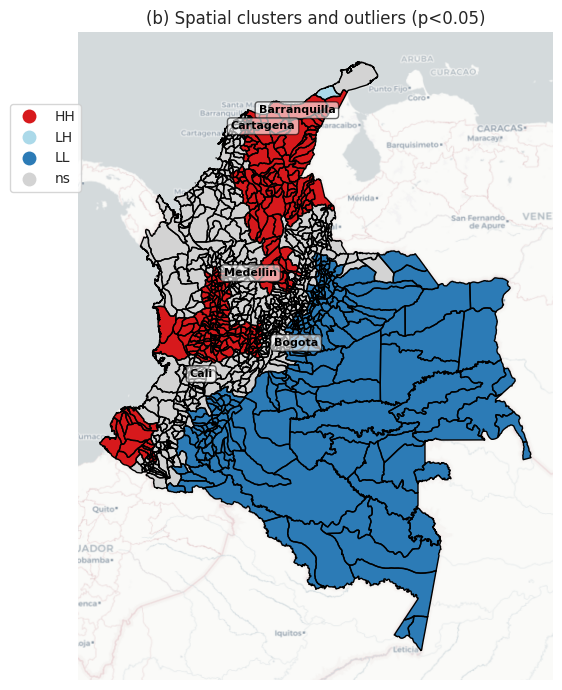

In [ ]:
# Adjust the aspect ratio for better readability
# Create a subplot with one plot
f, ax = plt.subplots(1, figsize=(10, 7))

# Plot Local Indicators of Spatial Association (LISA) clusters
# moranLocal is a Moran_Local object containing local Moran statistics
# gdf is a GeoDataFrame containing spatial data
# p is the significance level for identifying clusters
# legend_kwds is a dictionary containing keyword arguments for the legend
lisa_cluster(moranLocal_2016, gdf_pivoted, p=0.05, legend_kwds={'bbox_to_anchor':(0.02, 0.90)}, ax=ax)

# Plot the GeoDataFrame gdf with only the border (no filled polygons)
gdf_pivoted.plot(facecolor='none', edgecolor='black', ax=ax)

# Add a basemap to the plot using the contextily package
# crs is the coordinate reference system of gdf
# source specifies the basemap provider (CartoDB.Voyager/CartoDB.Positron)
# attribution=False removes the attribution from the basemap
cx.add_basemap(ax, crs=gdf_pivoted.crs.to_string(), source=cx.providers.CartoDB.Positron, attribution=False)

# Add a title to the plot for context
ax.set_title("(b) Spatial clusters and outliers (p<0.05)")

# Select the represetative municipalities
selected_municipios = gdf_pivoted[gdf_pivoted['ADM2_NAME'].isin(['Bogota', 'Medellin', 'Cali', "Cartagena", "Barranquilla"])]

# Compute the centroids
selected_municipios['centroid'] = selected_municipios.geometry.centroid

# Add the labels
for idx, row in selected_municipios.iterrows():
    ax.annotate(
        text=row['ADM2_NAME'],
        xy=(row['centroid'].x, row['centroid'].y),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=8,
        color='black',
        weight='bold',
        bbox=dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec="black",
            alpha=0.6
        ))
# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Save the plot as an image file with high DPI and tight bounding box
plt.savefig("lisaMAP_2016.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
# Add local Moran's I p-values to the GeoDataFrame
gdf_pivoted['lisa_2016'] = moranLocal_2016.p_sim
gdf_pivoted['lisa_2017'] = moranLocal_2017.p_sim
gdf_pivoted['lisa_2018'] = moranLocal_2018.p_sim
gdf_pivoted['lisa_2019'] = moranLocal_2019.p_sim
gdf_pivoted['lisa_2020'] = moranLocal_2020.p_sim
gdf_pivoted['lisa_2021'] = moranLocal_2021.p_sim

# Classify and assign cluster types based on significance levels
# If p-value is less than 0.05, assign cluster type based on quadrant (q)
gdf_pivoted.loc[moranLocal_2016.p_sim < 0.05, 'cluster_2016'] = moranLocal_2016.q[moranLocal_2016.p_sim < 0.05]

# Fill NaN values with 0 (for non-significant observations)
gdf_pivoted["cluster_2016"] = gdf_pivoted["cluster_2016"].fillna(0)

# Map cluster codes to descriptive labels
gdf_pivoted["cluster_2016"] = gdf_pivoted["cluster_2016"].map({
    0: "Not significant",   # No significant spatial autocorrelation
    1: "High-high",         # High value surrounded by high values (hotspot)
    2: "Low-high",          # Low value surrounded by high values
    3: "Low-low",           # Low value surrounded by low values (coldspot)
    4: "High-low",          # High value surrounded by low values
})

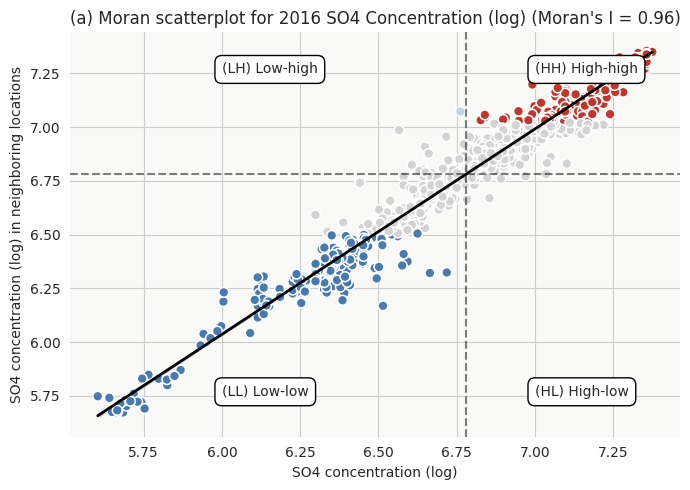

In [ ]:
# Set Seaborn theme to white grid for cleaner appearance
sns.set_style('whitegrid')

# Adjust the aspect ratio for better readability
f, ax = plt.subplots(1, figsize=(7, 5))

# Add the regression line with all grey points
sns.regplot(
    x="SO4SMASS_2016",
    y='wimds_2016',
    data=gdf_pivoted,
    scatter=True,
    marker='.',
    color='#d3d3d3',                    # Light gray for points
    line_kws={'linewidth': 2, 'color': 'black'}  # Black for regression line
)

# Overlay the significant points
sns.scatterplot(
    x='SO4SMASS_2016',
    y="wimds_2016",
    hue="cluster_2016",
    palette= [ "#4679b1","#c23429", "#d3d3d3", "#b5d8e7", "#efb16e"],  # #c23429 (Red) #4679b1 (Blue), #b5d8e7 (Light blue), #efb16e(Orange), #d3d3d3 (Light grey)
    data=gdf_pivoted,
    marker=".",
    s=200,  # Increase the marker size here
    alpha=0.99,  # No need for scatter_kws here
    legend=False  # Add this line to remove the legend
)

# Remove spines for a cleaner look
sns.despine(top=True, bottom=True, left=True, right=True)

# Add reference lines (average values)
plt.axvline(gdf_pivoted['SO4SMASS_2016'].mean(), c='black', alpha=0.5, linestyle='--')
plt.axhline(gdf_pivoted['wimds_2016'].mean(), c='black', alpha=0.5, linestyle='--')

# Annotate quadrants directly for clarity
ax.annotate('(HH) High-high', xy=(7, 7.25), xytext=(7, 7.25), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))
ax.annotate('(HL) High-low', xy=(7, 5.75), xytext=(7, 5.75), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))
ax.annotate('(LH) Low-high', xy=(6, 7.25), xytext=(6, 7.25), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))
ax.annotate('(LL) Low-low', xy=(6, 5.75), xytext=(6, 5.75), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))

# Add a title for context
ax.set_title(f"(a) Moran scatterplot for 2016 SO4 Concentration (log) (Moran's I = {moranI_2016})")

# Create more informative labels
ax.set_xlabel('SO4 concentration (log)')                 # Replace with the actual variable name
ax.set_ylabel('SO4 concentration (log) in neighboring locations')   # Replace if applicable

# Set background color for the plot
ax.set_facecolor('#f9f9f7')

# Save and show the plot
plt.tight_layout()
plt.savefig('lisaSC_2016.png', dpi=300, bbox_inches='tight')
plt.show()

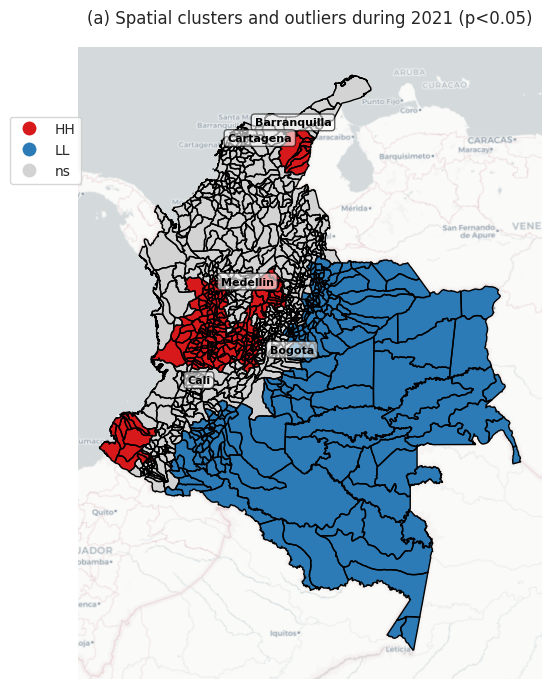

In [ ]:

# Adjust the aspect ratio for better readability
# Create a subplot with one plot
f, ax = plt.subplots(1, figsize=(10, 7))

# Plot Local Indicators of Spatial Association (LISA) clusters
# moranLocal is a Moran_Local object containing local Moran statistics
# gdf is a GeoDataFrame containing spatial data
# p is the significance level for identifying clusters
# legend_kwds is a dictionary containing keyword arguments for the legend
lisa_cluster(moranLocal_2021, gdf_pivoted, p=0.05, legend_kwds={'bbox_to_anchor':(0.02, 0.90)}, ax=ax)

# Plot the GeoDataFrame gdf with only the border (no filled polygons)
gdf_pivoted.plot(facecolor='none', edgecolor='black', ax=ax)

# Add a basemap to the plot using the contextily package
# crs is the coordinate reference system of gdf
# source specifies the basemap provider (CartoDB.Voyager/CartoDB.Positron)
# attribution=False removes the attribution from the basemap
cx.add_basemap(ax, crs=gdf_pivoted.crs.to_string(), source=cx.providers.CartoDB.Positron, attribution=False)

# Add a title to the plot for context
ax.set_title("(a) Spatial clusters and outliers during 2021 (p<0.05)")

# Select the represetative municipalities
selected_municipios = gdf_pivoted[gdf_pivoted['ADM2_NAME'].isin(['Bogota', 'Medellin', 'Cali', "Cartagena", "Barranquilla"])]

# Compute the centroids
selected_municipios['centroid'] = selected_municipios.geometry.centroid

# Add the labels
for idx, row in selected_municipios.iterrows():
    ax.annotate(
        text=row['ADM2_NAME'],
        xy=(row['centroid'].x, row['centroid'].y),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=8,
        color='black',
        weight='bold',
        bbox=dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec="black",
            alpha=0.6
        ))
# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Save the plot as an image file with high DPI and tight bounding box
plt.savefig("lisaMAP_2021.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
# Classify and assign cluster types based on significance levels
# If p-value is less than 0.05, assign cluster type based on quadrant (q)
gdf_pivoted.loc[moranLocal_2021.p_sim < 0.05, 'cluster_2021'] = moranLocal_2021.q[moranLocal_2021.p_sim < 0.05]

# Fill NaN values with 0 (for non-significant observations)
gdf_pivoted["cluster_2021"] = gdf_pivoted["cluster_2021"].fillna(0)

# Map cluster codes to descriptive labels
gdf_pivoted["cluster_2021"] = gdf_pivoted["cluster_2021"].map({
    0: "Not significant",   # No significant spatial autocorrelation
    1: "High-high",         # High value surrounded by high values (hotspot)
    2: "Low-high",          # Low value surrounded by high values
    3: "Low-low",           # Low value surrounded by low values (coldspot)
    4: "High-low",          # High value surrounded by low values
})

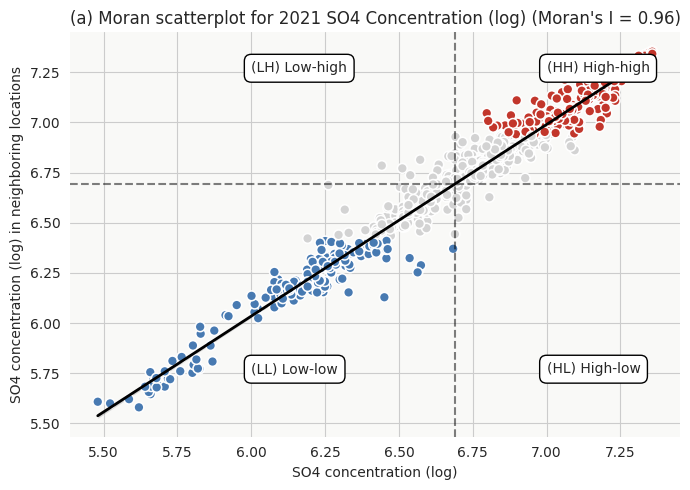

In [ ]:
# Set Seaborn theme to white grid for cleaner appearance
sns.set_style('whitegrid')

# Adjust the aspect ratio for better readability
f, ax = plt.subplots(1, figsize=(7, 5))

# Add the regression line with all grey points
sns.regplot(
    x="SO4SMASS_2021",
    y='wimds_2021',
    data=gdf_pivoted,
    scatter=True,
    marker='.',
    color='#d3d3d3',                    # Light gray for points
    line_kws={'linewidth': 2, 'color': 'black'}  # Black for regression line
)

# Overlay the significant points
sns.scatterplot(
    x='SO4SMASS_2021',
    y="wimds_2021",
    hue="cluster_2021",
    palette= [ "#4679b1", "#c23429", "#d3d3d3", "#b5d8e7", "#efb16e"],  # #c23429 (Red) #4679b1 (Blue), #b5d8e7 (Light blue), #efb16e(Orange), #d3d3d3 (Light grey)
    data=gdf_pivoted,
    marker=".",
    s=200,  # Increase the marker size here
    alpha=0.99,  # No need for scatter_kws here
    legend=False  # Add this line to remove the legend
)

# Remove spines for a cleaner look
sns.despine(top=True, bottom=True, left=True, right=True)

# Add reference lines (average values)
plt.axvline(gdf_pivoted['SO4SMASS_2021'].mean(), c='black', alpha=0.5, linestyle='--')
plt.axhline(gdf_pivoted['wimds_2021'].mean(), c='black', alpha=0.5, linestyle='--')

# Annotate quadrants directly for clarity
ax.annotate('(HH) High-high', xy=(7, 7.25), xytext=(7, 7.25), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))
ax.annotate('(HL) High-low', xy=(7, 5.75), xytext=(7, 5.75), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))
ax.annotate('(LH) Low-high', xy=(6, 7.25), xytext=(6, 7.25), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))
ax.annotate('(LL) Low-low', xy=(6, 5.75), xytext=(6, 5.75), fontsize=10,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='black', lw=1))

# Add a title for context
ax.set_title(f"(a) Moran scatterplot for 2021 SO4 Concentration (log) (Moran's I = {moranI_2016})")

# Create more informative labels
ax.set_xlabel('SO4 concentration (log)')                 # Replace with the actual variable name
ax.set_ylabel('SO4 concentration (log) in neighboring locations')   # Replace if applicable

# Set background color for the plot
ax.set_facecolor('#f9f9f7')

# Save and show the plot
plt.tight_layout()
plt.savefig('lisaSC_2021.png', dpi=300, bbox_inches='tight')
plt.show()

# Combined figures

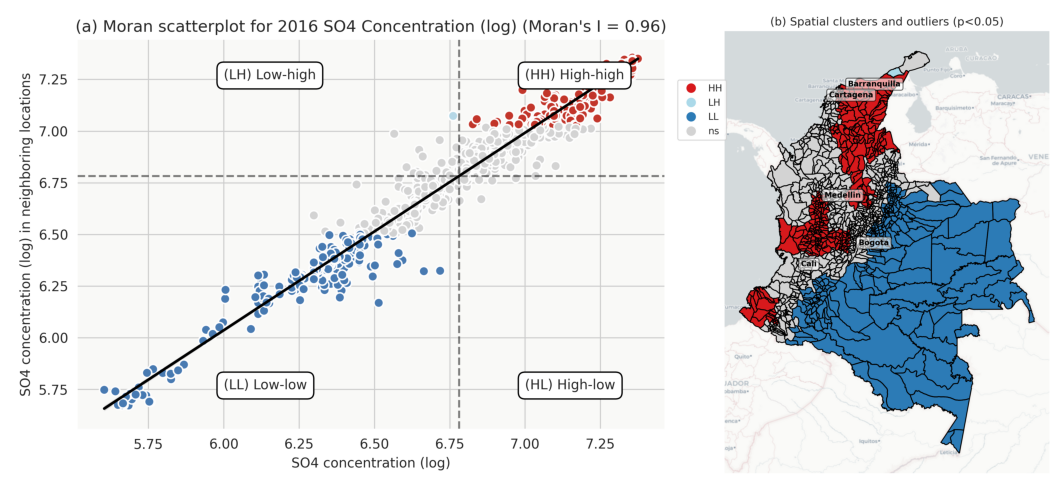

In [ ]:
# Combine figures

# Read the two PNG files
image1 = mpimg.imread('lisaSC_2016.png')
image2 = mpimg.imread('lisaMAP_2016.png')

# Create a figure and a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Display the first image in the first subplot
ax1.imshow(image1)
ax1.axis('off')  # Turn off axis for cleaner appearance

# Display the second image in the second subplot
ax2.imshow(image2)
ax2.axis('off')  # Turn off axis for cleaner appearance

# Adjust the horizontal spacing between subplots
plt.subplots_adjust(wspace=-0.6)

# Save and show the combined figure
plt.tight_layout()  # Ensure tight layout
plt.savefig('lisa1.png', dpi=300, bbox_inches='tight')  # Save the figure as PNG
plt.show()  # Display the combined figure

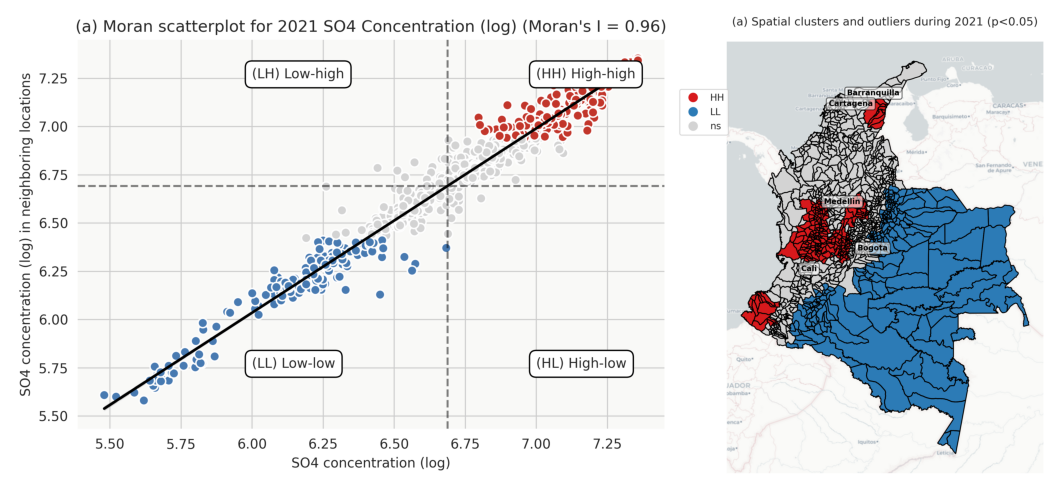

In [ ]:
# Combine figures

# Read the two PNG files
image1 = mpimg.imread('lisaSC_2021.png')
image2 = mpimg.imread('lisaMAP_2021.png')

# Create a figure and a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Display the first image in the first subplot
ax1.imshow(image1)
ax1.axis('off')  # Turn off axis for cleaner appearance

# Display the second image in the second subplot
ax2.imshow(image2)
ax2.axis('off')  # Turn off axis for cleaner appearance

# Adjust the horizontal spacing between subplots
plt.subplots_adjust(wspace=-0.6)

# Save and show the combined figure
plt.tight_layout()  # Ensure tight layout
plt.savefig('lisa2.png', dpi=300, bbox_inches='tight')  # Save the figure as PNG
plt.show()  # Display the combined figure

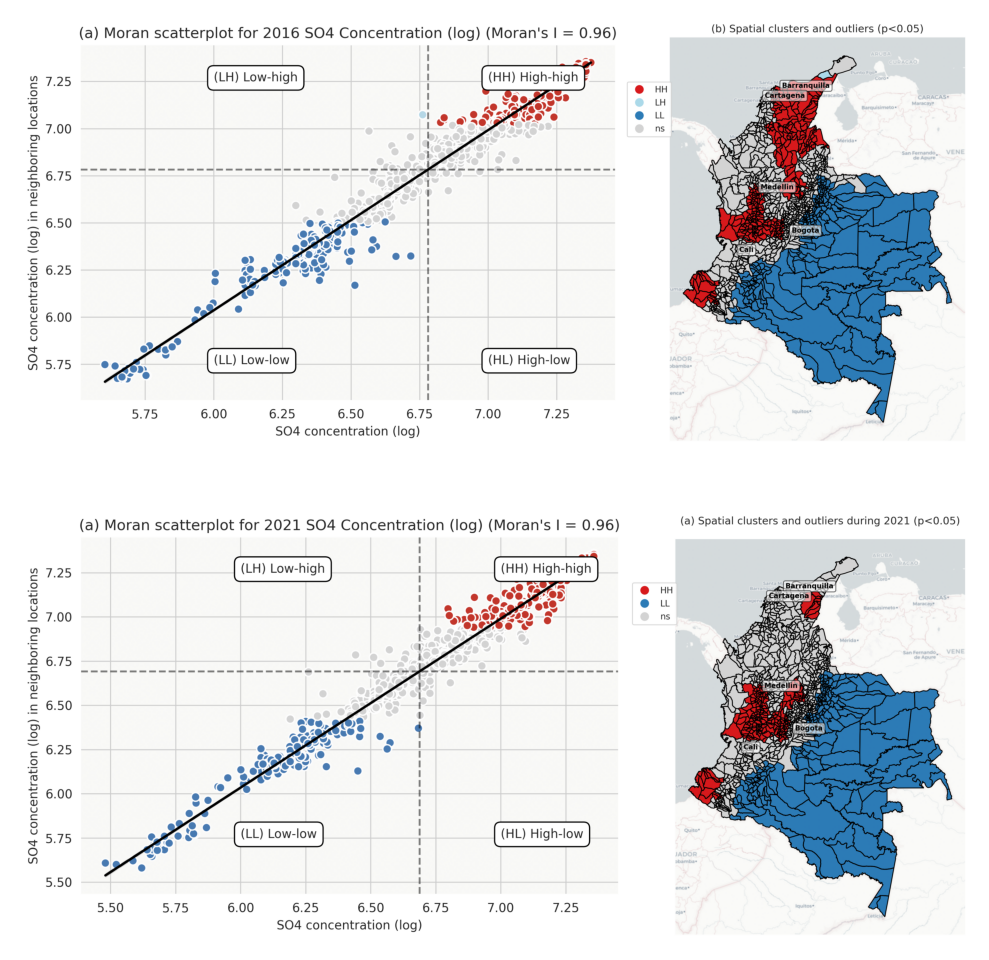

In [ ]:
# Combine figures

# Read the two PNG files
image1 = mpimg.imread('lisa1.png')
image2 = mpimg.imread('lisa2.png')

# Create a figure and a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Display the first image in the first subplot
ax1.imshow(image1)
ax1.axis('off')  # Turn off axis for cleaner appearance

# Display the second image in the second subplot
ax2.imshow(image2)
ax2.axis('off')  # Turn off axis for cleaner appearance

# Adjust the horizontal spacing between subplots
plt.subplots_adjust(wspace=-0.6)

# Save and show the combined figure
plt.tight_layout()  # Ensure tight layout
plt.savefig('so4_lisa_2016_2021.png', dpi=300, bbox_inches='tight')  # Save the figure as PNG
plt.show()  # Display the combined figure

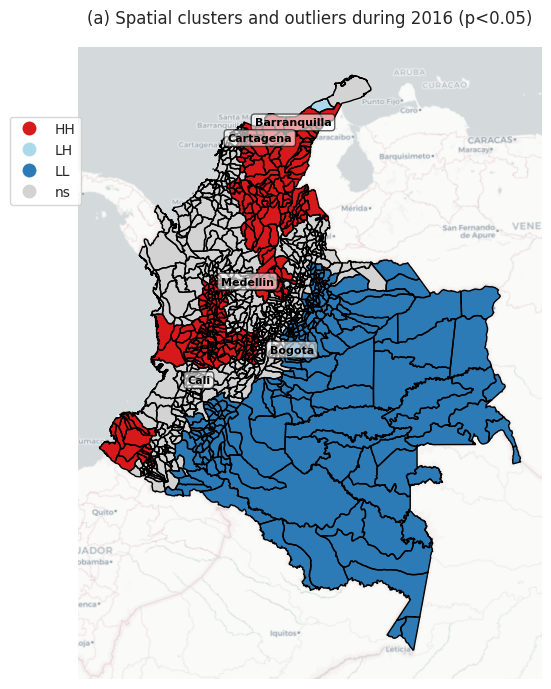

In [ ]:
# @title What happen with the clusters in the other years?
# Adjust the aspect ratio for better readability
# Create a subplot with one plot
f, ax = plt.subplots(1, figsize=(10, 7))

# Plot Local Indicators of Spatial Association (LISA) clusters
# moranLocal is a Moran_Local object containing local Moran statistics
# gdf is a GeoDataFrame containing spatial data
# p is the significance level for identifying clusters
# legend_kwds is a dictionary containing keyword arguments for the legend
lisa_cluster(moranLocal_2016, gdf_pivoted, p=0.05, legend_kwds={'bbox_to_anchor':(0.02, 0.90)}, ax=ax)

# Plot the GeoDataFrame gdf with only the border (no filled polygons)
gdf_pivoted.plot(facecolor='none', edgecolor='black', ax=ax)

# Add a basemap to the plot using the contextily package
# crs is the coordinate reference system of gdf
# source specifies the basemap provider (CartoDB.Voyager/CartoDB.Positron)
# attribution=False removes the attribution from the basemap
cx.add_basemap(ax, crs=gdf_pivoted.crs.to_string(), source=cx.providers.CartoDB.Positron, attribution=False)

# Add a title to the plot for context
ax.set_title("(a) Spatial clusters and outliers during 2016 (p<0.05)")

# Select the represetative municipalities
selected_municipios = gdf_pivoted[gdf_pivoted['ADM2_NAME'].isin(['Bogota', 'Medellin', 'Cali', "Cartagena", "Barranquilla"])]

# Compute the centroids
selected_municipios['centroid'] = selected_municipios.geometry.centroid

# Add the labels
for idx, row in selected_municipios.iterrows():
    ax.annotate(
        text=row['ADM2_NAME'],
        xy=(row['centroid'].x, row['centroid'].y),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=8,
        color='black',
        weight='bold',
        bbox=dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec="black",
            alpha=0.6
        ))
# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Save the plot as an image file with high DPI and tight bounding box
plt.savefig("lisaMAP_2016.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


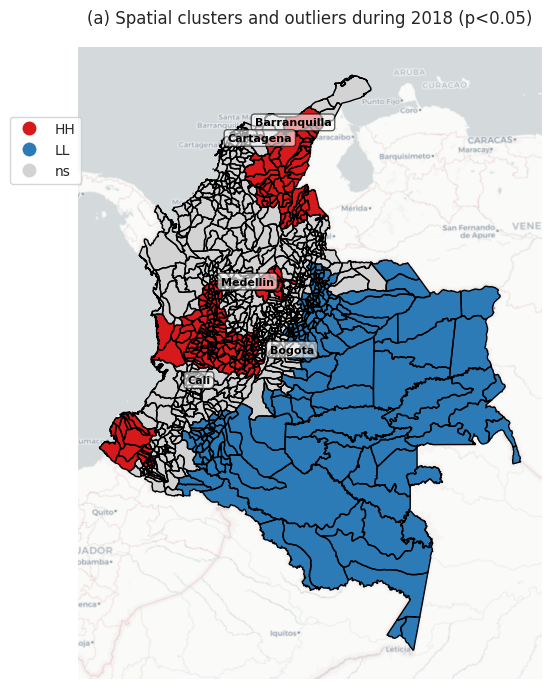

In [ ]:
# @title What happen with the clusters in the other years
# Adjust the aspect ratio for better readability
# Create a subplot with one plot
f, ax = plt.subplots(1, figsize=(10, 7))

# Plot Local Indicators of Spatial Association (LISA) clusters
# moranLocal is a Moran_Local object containing local Moran statistics
# gdf is a GeoDataFrame containing spatial data
# p is the significance level for identifying clusters
# legend_kwds is a dictionary containing keyword arguments for the legend
lisa_cluster(moranLocal_2018, gdf_pivoted, p=0.05, legend_kwds={'bbox_to_anchor':(0.02, 0.90)}, ax=ax)

# Plot the GeoDataFrame gdf with only the border (no filled polygons)
gdf_pivoted.plot(facecolor='none', edgecolor='black', ax=ax)

# Add a basemap to the plot using the contextily package
# crs is the coordinate reference system of gdf
# source specifies the basemap provider (CartoDB.Voyager/CartoDB.Positron)
# attribution=False removes the attribution from the basemap
cx.add_basemap(ax, crs=gdf_pivoted.crs.to_string(), source=cx.providers.CartoDB.Positron, attribution=False)

# Add a title to the plot for context
ax.set_title("(a) Spatial clusters and outliers during 2018 (p<0.05)")

# Select the represetative municipalities
selected_municipios = gdf_pivoted[gdf_pivoted['ADM2_NAME'].isin(['Bogota', 'Medellin', 'Cali', "Cartagena", "Barranquilla"])]

# Compute the centroids
selected_municipios['centroid'] = selected_municipios.geometry.centroid

# Add the labels
for idx, row in selected_municipios.iterrows():
    ax.annotate(
        text=row['ADM2_NAME'],
        xy=(row['centroid'].x, row['centroid'].y),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=8,
        color='black',
        weight='bold',
        bbox=dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec="black",
            alpha=0.6
        ))
# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Save the plot as an image file with high DPI and tight bounding box
plt.savefig("lisaMAP_2018.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

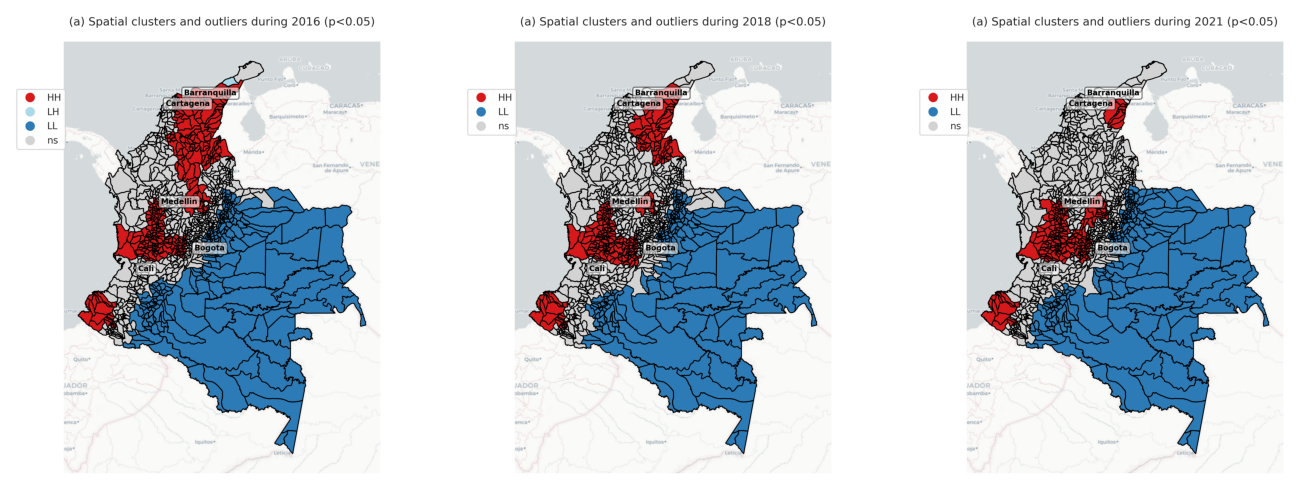

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read the three PNG files
image1 = mpimg.imread('lisaMAP_2016.png')
image2 = mpimg.imread('lisaMAP_2018.png')
image3 = mpimg.imread('lisaMAP_2021.png')

# Create a figure and a 1x3 grid of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))

# Display the first image in the first subplot
ax1.imshow(image1)
ax1.axis('off')  # Turn off axis for cleaner appearance

# Display the second image in the second subplot
ax2.imshow(image2)
ax2.axis('off')  # Turn off axis for cleaner appearance

# Display the third image in the third subplot
ax3.imshow(image3)
ax3.axis('off')  # Turn off axis for cleaner appearance

# Adjust the horizontal spacing between subplots
plt.subplots_adjust(wspace=0.1)

# Save and show the combined figure
plt.tight_layout()  # Ensure tight layout
plt.savefig('cluster_comparation.png', dpi=300, bbox_inches='tight')  # Save the figure as PNG
plt.show()  # Display the combined figure

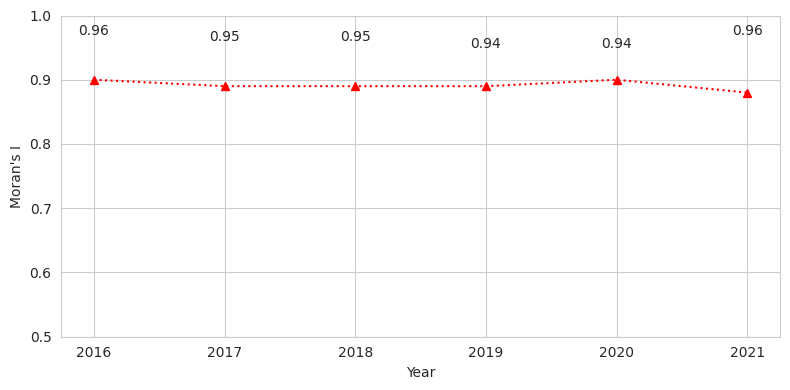

In [ ]:
import matplotlib.pyplot as plt

# dta
x = [2016, 2017, 2018, 2019, 2020, 2021]
y = [0.96, 0.95, 0.95, 0.94, 0.94, 0.96]

plt.figure(figsize=(8, 4))
plt.plot(x, y3, marker='^', color='red', linestyle=':')

plt.xlabel("Year")
plt.ylabel("Moran's I")

plt.ylim(0.5, 1)

for i, value in enumerate(y):
    plt.text(x[i], y[i] + 0.01, f"{value:.2f}", ha='center')

plt.grid(True)
plt.tight_layout()
plt.show()